# Free Course -> ND Association Rule

In [1]:
import psycopg2
import pandas as pd
import numpy as np
from apyori import apriori

In [2]:
conn_hardy = psycopg2.connect("dbname='analytics' user='awsdatapipeline' host='udacity-segment.c2zpsqalam7o.us-west-2.redshift.amazonaws.com' port='5439' password='Know.it.13818'")

In [3]:

sql_month = """
WITH user_list1 AS
  (SELECT DISTINCT a.user_id,a.course_key,a.join_time AS first_event,num_concept 
         ,bk.account_key AS bk,apps.applicant_id AS apps,aff.account_key AS aff
   FROM analytics_tables.course_enrollments a
   ---INNER JOIN analytics_tables.accounts AS acc
     ---ON a.user_id = acc.user_id AND acc.email NOT LIKE '%@gatech.edu%'
   LEFT JOIN analytics_tables.bookings bk
     ON a.user_id = bk.account_key and bk.charge_created_at < a.join_time
     AND is_full_refunded = 0 AND is_new_booking = 1
     AND category NOT IN ('None','deposit','career_advisor')
   LEFT JOIN analytics_tables.applications apps
     ON a.user_id = apps.applicant_id AND apps.submitted_at < a.join_time
   LEFT JOIN airflow.affiliate_deployments aff
     ON a.user_id = aff.account_key AND aff.deployed_at < a.join_time
     ---AND aff.affiliate_type IN ('Scholarships','MENA_acholarships','Enterprise')
     AND lower(aff.affiliate_type) NOT LIKE '%test%'
   INNER JOIN (SELECT course_key,count(distinct concept_key) AS num_concept 
               FROM analytics_tables.course_content
               WHERE course_is_public AND concept_is_public
               GROUP BY course_key) cou
      ON a.course_key = cou.course_key
   WHERE a.join_time >= '{start}' and a.join_time < '{end}'
     AND a.user_id not in (select distinct account_key from airflow.gt_members)
     ---AND a.course_key IN (SELECT KEY FROM analytics_tables.course_catalog WHERE public_listing)
  ),

user_list2 AS
  (SELECT DISTINCT a.user_id,a.course_key,a.first_event,num_concept 
         ,b.received_at,b.concept_key,b.lesson_key
   FROM user_list1 a
   INNER JOIN classroom.course_concept_completed b
     ON a.user_id = b.user_id and a.course_key = b.course_key
   WHERE a.bk IS NULL AND a.apps IS NULL AND a.aff IS NULL
  ),

enroll_list AS
  (SELECT DISTINCT a.user_id,a.course_key,a.first_event,a.received_at,a.concept_key,a.lesson_key,num_concept 
         ,bk.nd_key AS bk_nd_key,bk.charge_created_at
         ,(bk.charge_created_at::date-received_at::date)::int AS delta_to_bk
         ,(bk.charge_created_at::date-a.first_event::date)::int AS delta_to_bk_b
         ,apps.nd_key AS apps_nd_key,apps.submitted_at
         ,(apps.submitted_at::date-received_at::date)::int AS delta_to_apps
         ,(apps.submitted_at::date-a.first_event::date)::int AS delta_to_apps_b
         ,aff.nd_key AS aff_nd_key,aff.deployed_at
         ,(aff.deployed_at::date-received_at::date)::int AS delta_to_deploy
         ,(aff.deployed_at::date-a.first_event::date)::int AS delta_to_deploy_b
   FROM user_list2 a
   LEFT JOIN analytics_tables.bookings bk
     ON a.user_id = bk.account_key and bk.charge_created_at >= a.first_event
     AND bk.charge_created_at >= a.received_at
     AND is_full_refunded = 0 AND is_new_booking = 1
     AND category NOT IN ('None','deposit','career_advisor')
   LEFT JOIN analytics_tables.applications apps
     ON a.user_id = apps.applicant_id AND apps.submitted_at >= a.first_event
     AND apps.submitted_at >= a.received_at
   LEFT JOIN airflow.affiliate_deployments aff
     ON a.user_id = aff.account_key AND aff.deployed_at >= a.first_event
     AND aff.deployed_at >= a.received_at
  )

SELECT DISTINCT user_id,course_key,first_event,bk_nd_key AS nd_key,delta_to_bk_b AS delta_to_convert_b
      ,min(delta_to_bk) AS delta_to_convert,'BK' AS enrollment_type
      ,count(distinct concept_key) AS concept_completed_before_convert,num_concept 
FROM enroll_list
WHERE bk_nd_key IS NOT NULL AND charge_created_at > received_at
GROUP BY user_id,course_key,first_event,bk_nd_key,num_concept,delta_to_bk_b 
UNION
SELECT DISTINCT user_id,course_key,first_event,apps_nd_key AS nd_key,delta_to_apps_b AS delta_to_convert_b
      ,min(delta_to_apps) AS delta_to_convert,'APPS'
      ,count(distinct concept_key) AS concept_completed_before_convert,num_concept 
FROM enroll_list
WHERE apps_nd_key IS NOT NULL AND submitted_at > received_at
GROUP BY user_id,course_key,first_event,apps_nd_key,num_concept,delta_to_apps_b 
UNION
SELECT DISTINCT user_id,course_key,first_event,aff_nd_key AS nd_key,delta_to_deploy_b AS delta_to_convert_b
      ,min(delta_to_deploy) AS delta_to_convert,'BD'
      ,count(distinct concept_key) AS concept_completed_before_convert,num_concept 
FROM enroll_list
WHERE aff_nd_key IS NOT NULL AND deployed_at > received_at
GROUP BY user_id,course_key,first_event,aff_nd_key,num_concept,delta_to_deploy_b
UNION
SELECT DISTINCT user_id,course_key,first_event,null as nd_key,0 as delta_to_convert_b,0 as delta_to_convert,null
      ,0 as concept_completed_before_convert,num_concept 
FROM enroll_list 
WHERE bk_nd_key IS NULL AND apps_nd_key IS NULL AND aff_nd_key IS NULL
"""

In [4]:
month_list = ['2017-07-01','2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01','2018-01-01','2018-02-01']

df = pd.read_sql(sql_month.format(start='2017-06-01',end='2017-07-01'),conn_hardy)
print('2017-06-01','2017-07-01')

for i in range(len(month_list)-1):
    df_month = pd.read_sql(sql_month.format(start=month_list[i],end=month_list[i+1]),conn_hardy)
    df = pd.concat([df,df_month],axis=0)
    print(month_list[i],month_list[i+1])

2017-06-01 2017-07-01
2017-07-01 2017-08-01
2017-08-01 2017-09-01
2017-09-01 2017-10-01
2017-10-01 2017-11-01
2017-11-01 2017-12-01
2017-12-01 2018-01-01
2018-01-01 2018-02-01


In [5]:
df['nd_key_formatted'] = df['nd_key'].str[:5]
df['concept_finish'] = df['concept_completed_before_convert']/df['num_concept']
df.head()

,user_id,course_key,first_event,nd_key,delta_to_convert_b,delta_to_convert,enrollment_type,concept_completed_before_convert,num_concept,nd_key_formatted,concept_finish
0,10005277042,cs101,2017-06-21 03:14:57.549700,nd002,79,79,BK,1,509,nd002,0.001965
1,1014498732,ud775,2017-06-09 05:08:40.022770,nd801-br,234,0,BK,25,119,nd801,0.210084
2,10153389165,ud803,2017-06-30 01:26:10.432630,nd889-innlp,233,223,BK,39,132,nd889,0.295455
3,10174342399,ud827,2017-06-14 01:06:49.390920,nd009,6,6,BK,1,448,nd009,0.002232
4,10206313654,st101,2017-06-21 17:29:25.341430,nd889,186,146,BK,264,534,nd889,0.494382


In [9]:
df.nd_key_formatted.unique()

array(['nd002', 'nd801', 'nd889', 'nd009', 'nd018', 'nd001', 'nd110',
       'nd008', 'nd003', 'nd019', 'CertA', 'nd803', 'nd017', 'nd000',
       'nd101', 'nd004', 'nd209', 'nd013', 'nd100', 'nd124', 'nd111',
       'nd113', 'nd787', 'nd112', 'nd116', 'nd114', 'nd201', 'nd818',
       'nd115', 'grow-', 'googl', 'omac-', 'ndBer', 'att-s', 'nd022',
       'nd024', 'ud002', 'ud004', 'ud851', 'ud834', 'ud304', 'ud803',
       'ud899', 'ud893', 'ud001', 'nd357', None, 'pa004', 'nd319', 'nd006',
       'nd301', 'nd109', 'nd041', 'nd117', 'nd042', 'nd102'], dtype=object)

In [10]:
df_t = df.groupby(['user_id','nd_key_formatted'])['course_key'].apply(lambda x: ', '.join(x)).reset_index()
df_t

,user_id,nd_key_formatted,course_key
0,10000152016,nd000,"ud827, ud036, cs101"
1,10000390791,grow-,"ud730, ud304, ud775, cs271, ud834"
2,10000392286,googl,ud1110
3,10001046111,googl,"ud000, ud197, ud283, ud282"
4,10001046111,nd113,"ud000, ud197, ud283, ud282"
5,10001046111,ud834,"ud000, ud197, ud282, ud283"
6,10001047944,nd113,"ud810, ud169"
7,10001369271,nd018,ud827
8,10001374522,nd100,"cs101, ud1110"
9,10001374596,googl,ud851


In [11]:
df_t["courses"] = df_t["course_key"] + ', ' + df_t["nd_key_formatted"]
df_t.head()

,user_id,nd_key_formatted,course_key,courses
0,10000152016,nd000,"ud827, ud036, cs101","ud827, ud036, cs101, nd000"
1,10000390791,grow-,"ud730, ud304, ud775, cs271, ud834","ud730, ud304, ud775, cs271, ud834, grow-"
2,10000392286,googl,ud1110,"ud1110, googl"
3,10001046111,googl,"ud000, ud197, ud283, ud282","ud000, ud197, ud283, ud282, googl"
4,10001046111,nd113,"ud000, ud197, ud283, ud282","ud000, ud197, ud283, ud282, nd113"


## by ND

In [12]:
nd_list = ['nd801', 'nd013', 'nd002', 'nd009', 'nd101', 'nd001', 'nd100',
           'nd113', 'nd019', 'nd124', 'nd018', 'nd003', 'nd112', 'nd000',
           'nd004', 'nd889', 'nd803', 'nd008', 'nd209', 'nd111', 'nd017',
           'nd110', 'nd114', 'nd201', 'nd116', 'nd818', 'nd115', 'nd787',
           'nd024', 'nd022', 'nd357', 'nd319', 'nd006', 'nd117', 'nd102']
results = {}

for i in nd_list:
    print(i)
    transactions = []
    for j in df_t[df_t['nd_key_formatted']==i].courses:
        transactions.append([j])
    rules = apriori(transactions, min_support = 0.1, min_confidence = 0.1, min_lift = 1, min_length = 2)
    results[i] = list(rules)
    print(results[i])
    print('\n')

nd801
[]


nd013
[]


nd002
[]


nd009
[]


nd101
[RelationRecord(items=frozenset({'ud730, nd101'}), support=0.11477411477411477, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'ud730, nd101'}), confidence=0.11477411477411477, lift=1.0)])]


nd001
[RelationRecord(items=frozenset({'ud304, nd001'}), support=0.10254491017964072, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'ud304, nd001'}), confidence=0.10254491017964072, lift=1.0)])]


nd100
[]


nd113
[]


nd019
[]


nd124
[]


nd018
[]


nd003
[]


nd112
[]


nd000
[RelationRecord(items=frozenset({'cs101, nd000'}), support=0.12752721617418353, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'cs101, nd000'}), confidence=0.12752721617418353, lift=1.0)])]


nd004
[RelationRecord(items=frozenset({'ud777, nd004'}), support=0.13344887348353554, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'ud777, nd00

## all courses and ND combined

In [13]:
nd_list = ['nd801', 'nd013', 'nd002', 'nd009', 'nd101', 'nd001', 'nd100',
           'nd113', 'nd019', 'nd124', 'nd018', 'nd003', 'nd112', 'nd000',
           'nd004', 'nd889', 'nd803', 'nd008', 'nd209', 'nd111', 'nd017',
           'nd110', 'nd114', 'nd201', 'nd116', 'nd818', 'nd115', 'nd787',
           'nd024', 'nd022', 'nd357', 'nd319', 'nd006', 'nd117', 'nd102']
df_convert = pd.DataFrame()
for i in nd_list:
    d = df[df['nd_key_formatted']==i]
    df_convert = pd.concat([df_convert,d],axis=0)

In [14]:
df_convert.nd_key_formatted.unique()

array(['nd801', 'nd013', 'nd002', 'nd009', 'nd101', 'nd001', 'nd100',
       'nd113', 'nd019', 'nd124', 'nd018', 'nd003', 'nd112', 'nd000',
       'nd004', 'nd889', 'nd803', 'nd008', 'nd209', 'nd111', 'nd017',
       'nd110', 'nd114', 'nd201', 'nd116', 'nd818', 'nd115', 'nd787',
       'nd024', 'nd022', 'nd357', 'nd319', 'nd006', 'nd117', 'nd102'], dtype=object)

In [15]:
df_nd = df_convert[['user_id','nd_key_formatted']]
df_c = df_convert[['user_id','course_key']]
col = ['user_id','course']
df_nd.columns = col
df_c.columns = col
all = pd.concat([df_nd.dropna(),df_c.dropna()],axis=0)

In [16]:
len(all.user_id.unique())

23034

In [18]:
all_transactions = all.groupby('user_id')['course'].apply(lambda x: list(x)).tolist()
all_rules = apriori(all_transactions, min_support = 0.01, min_confidence = 0.5, min_lift = 1.1, min_length = 2)
all_results = list(all_rules)
all_results

[RelationRecord(items=frozenset({'ud777', 'nd004'}), support=0.015108101067986456, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ud777'}), items_add=frozenset({'nd004'}), confidence=0.7002012072434608, lift=13.976113178202667)]),
 RelationRecord(items=frozenset({'ud201', 'ud827'}), support=0.016801250325605626, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ud201'}), items_add=frozenset({'ud827'}), confidence=0.6333878887070377, lift=11.265989674500315)]),
 RelationRecord(items=frozenset({'ud836', 'ud834'}), support=0.01936268125379873, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ud836'}), items_add=frozenset({'ud834'}), confidence=0.7045813586097947, lift=9.841920566536087)]),
 RelationRecord(items=frozenset({'ud839', 'ud834'}), support=0.0131978813927238, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ud839'}), items_add=frozenset({'ud834'}), confidence=0.64, lift=8.93981807155852)]),
 RelationRecord(items=frozenset({'ud836', 'u

### modeling by nd

In [19]:
nd_list = ['nd801', 'nd013', 'nd002', 'nd009', 'nd101', 'nd001', 'nd100',
           'nd113', 'nd019', 'nd124', 'nd018', 'nd003', 'nd112', 'nd000',
           'nd004', 'nd889', 'nd803', 'nd008', 'nd209', 'nd111', 'nd017',
           'nd110', 'nd114', 'nd201', 'nd116', 'nd818', 'nd115', 'nd787',
           'nd024', 'nd022', 'nd357', 'nd319', 'nd006', 'nd117', 'nd102']
df_convert = pd.DataFrame()
for i in nd_list:
    d = df[df['nd_key_formatted']==i]
    df_convert = pd.concat([df_convert,d],axis=0)

In [20]:
df_pivot = pd.pivot_table(df_convert, values='concept_finish', index=['user_id','nd_key_formatted'],columns=['course_key'], aggfunc=np.sum).fillna(0).reset_index()

In [21]:
df_pivot.shape

(24842, 221)

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_result = dict()

for i in nd_list:
    d = df_pivot
    d['target'] = 0
    d.loc[d['nd_key_formatted'] == i, 'target'] = 1
    
    col = list(d.columns[2:221])
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(d[col], d['target'])
    
    n = pd.concat([pd.DataFrame(col),pd.DataFrame(clf.feature_importances_)],axis=1)
    n.columns = ['course','feature_importance']
    print(i)
    print(n.sort_values(by='feature_importance',ascending=False).head(10))
    rf_result[i] = list(n.sort_values(by='feature_importance',ascending=False).head(5).reset_index().course)
    print('\n')

nd801
    course  feature_importance
146  ud775            0.253499
168  ud845            0.184900
170  ud851            0.093515
166  ud839            0.077660
180  ud862            0.069784
169  ud849            0.066634
154  ud808            0.056506
96   ud283            0.046041
159  ud825            0.037771
176  ud855            0.023775


nd013
     course  feature_importance
16    cs373            0.247201
150   ud803            0.137690
146   ud775            0.085595
142   ud730            0.079655
83    ud210            0.070665
185  ud875C            0.056851
68    ud120            0.053667
94    ud281            0.047302
76    ud189            0.037694
156   ud810            0.037448


nd002
     course  feature_importance
110   ud359            0.223337
160   ud827            0.173735
138   ud651            0.172881
46   ud1006            0.093656
1     cs046            0.057777
77    ud197            0.057279
48   ud1008            0.041176
70    ud150            0.0249

nd116
        course  feature_importance
117      ud407            0.165576
145      ud774            0.117138
137      ud617            0.101825
53      ud1022            0.099205
0       bio110            0.094200
84       ud245            0.078181
106      ud354            0.061355
102      ud325            0.056921
62      ud1038            0.054552
18   design101            0.049749


nd818
     course  feature_importance
168   ud845            0.150462
170   ud851            0.125731
161   ud834            0.093903
1     cs046            0.087417
36    ud009            0.084645
60   ud1031            0.067768
142   ud730            0.062155
68    ud120            0.060357
12    cs271            0.051830
160   ud827            0.048170


nd115
     course  feature_importance
68    ud120            0.138436
38    ud032            0.099850
85    ud248            0.093753
46   ud1006            0.093383
77    ud197            0.089467
123   ud501            0.075820
177   ud858      

In [44]:
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

for i in nd_list:
    print('\n')
    print(i)
    print('\n')
    d = df_pivot[df_pivot['nd_key_formatted'] == i]
    for j in rf_result[i]:
        o = d[[j]].apply(lambda x: pd.cut(x, bins=[0.0,0.2,0.4,0.6,0.8,1.0]).value_counts())
        o['%'] = o[[j]] / o[[j]].sum()
        print(o)
        print('\n')



nd801


course_key  ud775         %
(0.0, 0.2]     78  0.472727
(0.8, 1.0]     45  0.272727
(0.2, 0.4]     17  0.103030
(0.6, 0.8]     15  0.090909
(0.4, 0.6]     10  0.060606


course_key  ud845         %
(0.8, 1.0]     44  0.458333
(0.0, 0.2]     31  0.322917
(0.4, 0.6]      9  0.093750
(0.2, 0.4]      8  0.083333
(0.6, 0.8]      4  0.041667


course_key  ud851         %
(0.0, 0.2]    174  0.693227
(0.2, 0.4]     23  0.091633
(0.8, 1.0]     22  0.087649
(0.4, 0.6]     18  0.071713
(0.6, 0.8]     14  0.055777


course_key  ud839         %
(0.8, 1.0]     63  0.516393
(0.0, 0.2]     31  0.254098
(0.6, 0.8]     11  0.090164
(0.2, 0.4]     10  0.081967
(0.4, 0.6]      7  0.057377


course_key  ud862         %
(0.0, 0.2]     29  0.508772
(0.8, 1.0]     17  0.298246
(0.4, 0.6]      6  0.105263
(0.6, 0.8]      3  0.052632
(0.2, 0.4]      2  0.035088




nd013


course_key  cs373         %
(0.0, 0.2]    285  0.744125
(0.2, 0.4]     44  0.114883
(0.4, 0.6]     25  0.065274
(0.8, 1.0]     15 



course_key  ud257         %
(0.0, 0.2]     14  0.823529
(0.2, 0.4]      2  0.117647
(0.4, 0.6]      1  0.058824
(0.8, 1.0]      0  0.000000
(0.6, 0.8]      0  0.000000




nd003


course_key  ud585         %
(0.0, 0.2]     28  0.444444
(0.8, 1.0]     25  0.396825
(0.2, 0.4]      7  0.111111
(0.4, 0.6]      2  0.031746
(0.6, 0.8]      1  0.015873


course_key  ud1027         %
(0.8, 1.0]       7  0.636364
(0.4, 0.6]       2  0.181818
(0.2, 0.4]       1  0.090909
(0.0, 0.2]       1  0.090909
(0.6, 0.8]       0  0.000000


course_key  ud788         %
(0.0, 0.2]     11  0.523810
(0.8, 1.0]      4  0.190476
(0.2, 0.4]      4  0.190476
(0.4, 0.6]      2  0.095238
(0.6, 0.8]      0  0.000000


course_key  ud774         %
(0.8, 1.0]      3  0.428571
(0.0, 0.2]      3  0.428571
(0.2, 0.4]      1  0.142857
(0.6, 0.8]      0  0.000000
(0.4, 0.6]      0  0.000000


course_key  ud576         %
(0.8, 1.0]      5  0.714286
(0.4, 0.6]      1  0.142857
(0.0, 0.2]      1  0.142857
(0.6, 0.8]      0  0

course_key  ud292    %
(0.6, 0.8]      2  0.4
(0.0, 0.2]      2  0.4
(0.2, 0.4]      1  0.2
(0.8, 1.0]      0  0.0
(0.4, 0.6]      0  0.0


course_key  ud359     %
(0.0, 0.2]     24  0.96
(0.2, 0.4]      1  0.04
(0.8, 1.0]      0  0.00
(0.6, 0.8]      0  0.00
(0.4, 0.6]      0  0.00


course_key  st101      %
(0.0, 0.2]     35  0.875
(0.2, 0.4]      3  0.075
(0.8, 1.0]      1  0.025
(0.4, 0.6]      1  0.025
(0.6, 0.8]      0  0.000


course_key  ud303    %
(0.8, 1.0]      1  1.0
(0.6, 0.8]      0  0.0
(0.4, 0.6]      0  0.0
(0.2, 0.4]      0  0.0
(0.0, 0.2]      0  0.0


course_key  ud1006         %
(0.0, 0.2]       8  0.888889
(0.4, 0.6]       1  0.111111
(0.8, 1.0]       0  0.000000
(0.6, 0.8]       0  0.000000
(0.2, 0.4]       0  0.000000




nd114


course_key  ud1014     %
(0.6, 0.8]       3  0.75
(0.2, 0.4]       1  0.25
(0.8, 1.0]       0  0.00
(0.4, 0.6]       0  0.00
(0.0, 0.2]       0  0.00


course_key  ud892    %
(0.8, 1.0]      1  1.0
(0.6, 0.8]      0  0.0
(0.4, 0.6]     

(0.0, 0.2]      0 NaN


course_key  ud834   %
(0.8, 1.0]      0 NaN
(0.6, 0.8]      0 NaN
(0.4, 0.6]      0 NaN
(0.2, 0.4]      0 NaN
(0.0, 0.2]      0 NaN


course_key  cs373   %
(0.8, 1.0]      0 NaN
(0.6, 0.8]      0 NaN
(0.4, 0.6]      0 NaN
(0.2, 0.4]      0 NaN
(0.0, 0.2]      0 NaN


course_key  ud730   %
(0.8, 1.0]      0 NaN
(0.6, 0.8]      0 NaN
(0.4, 0.6]      0 NaN
(0.2, 0.4]      0 NaN
(0.0, 0.2]      0 NaN


course_key  ud803   %
(0.8, 1.0]      0 NaN
(0.6, 0.8]      0 NaN
(0.4, 0.6]      0 NaN
(0.2, 0.4]      0 NaN
(0.0, 0.2]      0 NaN




nd102


course_key  ud1014    %
(0.0, 0.2]       1  1.0
(0.8, 1.0]       0  0.0
(0.6, 0.8]       0  0.0
(0.4, 0.6]       0  0.0
(0.2, 0.4]       0  0.0


course_key  ud120   %
(0.8, 1.0]      0 NaN
(0.6, 0.8]      0 NaN
(0.4, 0.6]      0 NaN
(0.2, 0.4]      0 NaN
(0.0, 0.2]      0 NaN


course_key  ud109    %
(0.0, 0.2]      1  1.0
(0.8, 1.0]      0  0.0
(0.6, 0.8]      0  0.0
(0.4, 0.6]      0  0.0
(0.2, 0.4]      0  0.0


course_key

In [35]:
df_nd101 = df_pivot[df_pivot['nd_key_formatted'] == 'nd101']

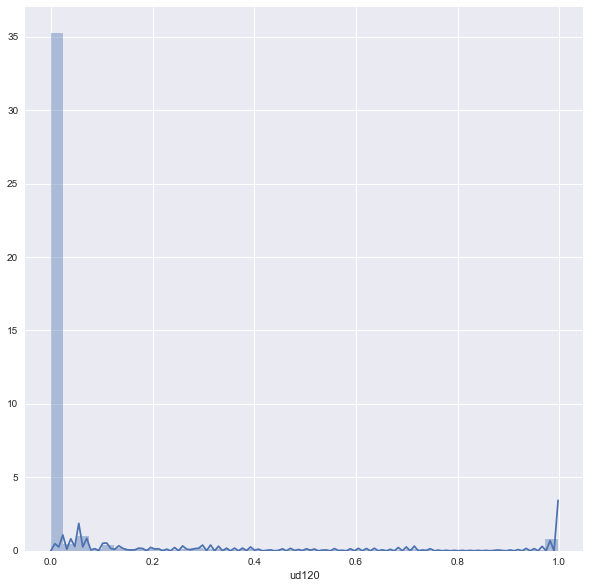

In [38]:
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
sns.distplot(df_nd101[(df_nd101['ud120']>=0)&(df_nd101['ud120']<=1)].ud120)

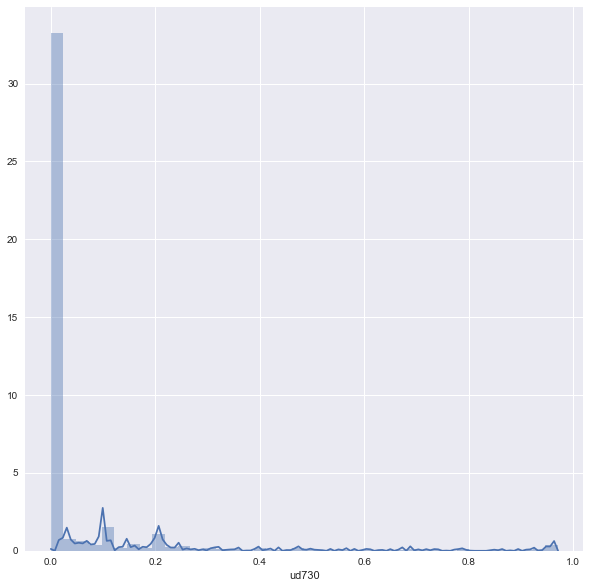

In [40]:
plt.figure(figsize=(10,10))
sns.distplot(df_nd101[(df_nd101['ud730']>=0)&(df_nd101['ud730']<=1)].ud730)

### convert when active

In [41]:
df_pivot_days = pd.pivot_table(df_convert, values='delta_to_convert', index=['user_id','nd_key_formatted'],columns=['course_key'], aggfunc=np.sum).fillna(0).reset_index()

In [42]:
df_nd101_d = df_pivot_days[df_pivot_days['nd_key_formatted'] == 'nd101']
df_nd101_d.head()

course_key,user_id,nd_key_formatted,bio110,cs046,cs101,cs212,cs215,cs222,cs253,cs255,...,ud954,ud955,ud976,ud977,ud978,ud979,ud980,ud981,ud989,ud990
51,10026690799,nd101,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,10040323787,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,10041216643,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,10041356996,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,10042017833,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


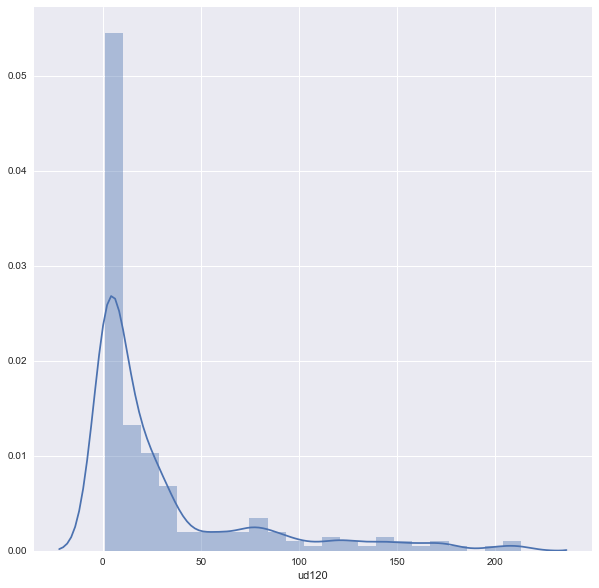

In [43]:
plt.figure(figsize=(10,10))
sns.distplot(df_nd101_d[df_nd101_d['ud120']>0].ud120)

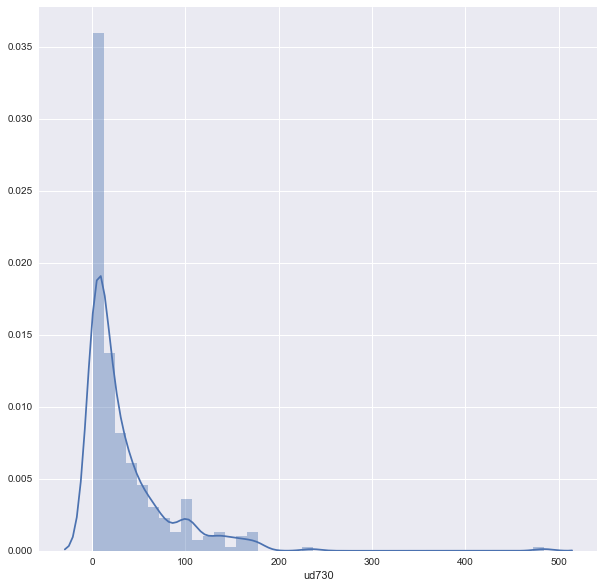

In [44]:
plt.figure(figsize=(10,10))
sns.distplot(df_nd101_d[df_nd101_d['ud730']>0].ud730)

### convert since first join

In [39]:
df_pivot_days_b = pd.pivot_table(df_convert, values='delta_to_convert_b', index=['user_id','nd_key_formatted'],columns=['course_key'], aggfunc=np.sum).fillna(0).reset_index()

In [40]:
df_nd101_d_b = df_pivot_days_b[df_pivot_days_b['nd_key_formatted'] == 'nd101']
df_nd101_d_b.head()

course_key,user_id,nd_key_formatted,bio110,cs046,cs101,cs212,cs215,cs222,cs253,cs255,...,ud954,ud955,ud976,ud977,ud978,ud979,ud980,ud981,ud989,ud990
51,10026690799,nd101,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,10040323787,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,10041216643,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,10041356996,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,10042017833,nd101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


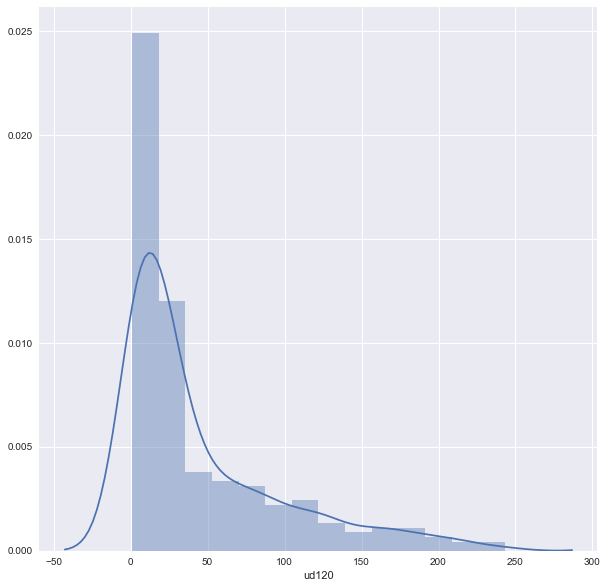

In [55]:
plt.figure(figsize=(10,10))
sns.distplot(df_nd101_d_b[df_nd101_d_b['ud120']>0].ud120)

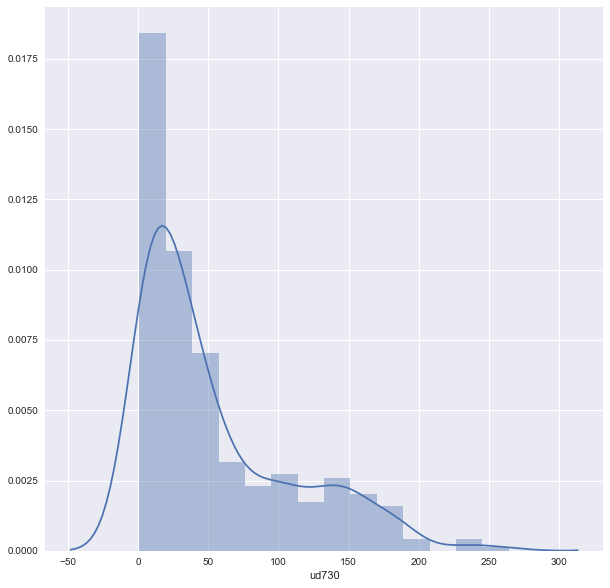

In [48]:
plt.figure(figsize=(10,10))
sns.distplot(df_nd101_d_b[df_nd101_d_b['ud730']>0].ud730)

In [ ]:
conn_hardy_admin = psycopg2.connect("dbname='analytics' user='udacian' host='udacity-segment.c2zpsqalam7o.us-west-2.redshift.amazonaws.com' port='5439' password='AYEe&mtihMqtXQbWR2xgWrhmKzd6]F'")


In [ ]:
sql_c = '''
--- found 198 users have been exposed to Ads and non-Ads, removing them from pool
--- measure unit: user_id + course_key instead of user_id
--- excluded @gatech.edu emails
WITH pool1 AS
  (SELECT ev.user_id,ev.course_key,cou.num_concept
         ,min(ev.timestamp) AS first_event,count(DISTINCT ev.variation_id) AS _count
   FROM (SELECT user_id,course_key,"timestamp",variation_id,coalesce(sku_targeted,sku) AS sku_targeted
         FROM frontend_classroom.course_free_course_ad_displayed
         UNION
         SELECT user_id,course_key,"timestamp",variation_id,sku_targeted
         FROM frontend_classroom.course_free_course_ad_started
         WHERE experiment_id = 'free-course-ad-test-001'
         ) AS ev
   INNER JOIN analytics_tables.accounts AS a 
     ON a.user_id = ev.user_id AND a.email NOT LIKE '%@gatech.edu%'
   LEFT JOIN (SELECT course_key,count(distinct concept_key) AS num_concept 
               FROM analytics_tables.course_content
               WHERE course_is_public AND concept_is_public
               GROUP BY course_key) cou
      ON ev.course_key = cou.course_key
   GROUP BY ev.user_id,ev.course_key,num_concept
   HAVING count(DISTINCT ev.variation_id) = 1
  ),

pool2 AS
  (SELECT ev.user_id,ev.course_key,e.join_time,ev.first_event,ev.num_concept
         ,1.0*count(distinct b.concept_key)/ev.num_concept AS concept_completion 
   FROM pool1 ev
   LEFT JOIN analytics_tables.course_enrollments e ON ev.user_id = e.user_id AND ev.course_key = e.course_key
   LEFT JOIN classroom.course_concept_completed b
     ON ev.user_id = b.user_id and ev.course_key = b.course_key
   GROUP BY ev.user_id,ev.course_key,e.join_time,ev.first_event,ev.num_concept
  ),

--- exclude students who has either enrolled or applied before exposed to this ad
pool AS
  (SELECT distinct a.user_id,a.course_key,a.first_event,a.join_time,a.concept_completion
         ,bk.account_key AS bk,apps.applicant_id AS apps
   FROM pool2 a 
   LEFT JOIN analytics_tables.bookings bk
     ON a.user_id = bk.account_key and bk.charge_created_at < a.first_event
     AND bk.is_full_refunded = 0 AND bk.is_new_booking = 1
     AND bk.category NOT IN ('None','deposit','career_advisor')
   LEFT JOIN analytics_tables.applications apps
     ON a.user_id = apps.applicant_id AND apps.submitted_at < a.first_event
  )

--- Find bks and apps after ads displayed
SELECT DISTINCT ev.variation_id,ev.user_id,ev.course_key,pool.join_time,pool.concept_completion,
       lc.user_id AS user_clicked_ad,
       ev.sku_targeted AS nd_key,pool.first_event,
       ev.user_id||'-'||ev.course_key AS id,lc.user_id||'-'||lc.course_key AS clicked_ad_id,
       bk.nd_key AS bk_nd,ap.nd_key AS ap_nd,
       lc.timestamp AS timestamp_clicked,bk.charge_created_at,ap.submitted_at,
       bk.charge_created_at::date - ev.timestamp::date AS bk_convert,
       bk.charge_created_at::date - pool.join_time::date AS bk_convert_join,
       ap.submitted_at::date - ev.timestamp::date AS ap_convert,
       ap.submitted_at::date - pool.join_time::date AS ap_convert_join
FROM (SELECT user_id,course_key,"timestamp",variation_id,coalesce(sku_targeted,sku) AS sku_targeted
      FROM frontend_classroom.course_free_course_ad_displayed
      UNION
      SELECT user_id,course_key,"timestamp",variation_id,sku_targeted AS sku_targeted
      FROM frontend_classroom.course_free_course_ad_started
      WHERE experiment_id = 'free-course-ad-test-001'
     ) AS ev
INNER JOIN pool 
  ON ev.user_id = pool.user_id AND ev.course_key = pool.course_key
LEFT JOIN "frontend_classroom"."course_free_course_ad_clicked" AS lc 
  ON lc.user_id = ev.user_id AND lc.course_key = ev.course_key -- matching at course_key
  AND lc.timestamp >= ev.timestamp
  AND (lc.experiment_id = 'free-course-ad-displayed' 
   OR lc.experiment_id = 'free-course-ad-test-001' 
   OR lc.experiment_id IS NULL)
LEFT JOIN analytics_tables.bookings AS bk 
   ON bk.account_key = ev.user_id
   AND bk.charge_created_at >= ev.timestamp
   AND bk.is_full_refunded = 0 AND bk.is_new_booking = 1
   AND bk.category NOT IN ('None','deposit','career_advisor')
LEFT JOIN analytics_tables.applications AS ap 
   ON ap.applicant_id = ev.user_id
   AND ap.submitted_at >= ev.timestamp
WHERE (ev.variation_id = 'EXPT' OR (ev.variation_id = 'CTRL' AND lc.user_id IS NULL))
  AND pool.bk IS NULL AND pool.apps IS NULL
'''

In [ ]:
df_c = pd.read_sql(sql_c,conn_hardy_admin)